In [49]:
import pandas as pd
import numpy as np
from DB_Manager import DatabaseManager
import plotly.express as px
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans

In [50]:
db = DatabaseManager()
feeder = 1
actuals = db.fetch_data(feeder, "2024-01-01", "2024-07-30")[['Net_Load_Demand']]
actuals_pivot = actuals.pivot_table(index=actuals.index.date, columns=actuals.index.hour, values='Net_Load_Demand')
actuals_pivot.index = pd.to_datetime(actuals_pivot.index)
actuals_pivot

Fetching data for Feeder 1 from 2024-01-01 to 2024-07-30...
Fetched 5016 records.


Timestamp,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2024-01-01,5707.900000,5609.932857,5569.238889,5369.317500,5233.525000,5185.377143,5178.864000,5034.778889,3678.272000,2289.448182,...,2075.137583,463.398692,2062.022250,3974.641667,6225.494167,6980.613333,7058.467000,6873.920000,6604.172857,6278.662000
2024-01-02,5948.418571,5536.313333,5268.770000,5065.176667,4991.500000,4978.698333,5422.044167,5627.592727,4549.866667,4038.590000,...,1124.245000,2845.446100,3201.345000,4663.803636,6759.467000,7622.545000,7541.767000,7295.842222,6880.653333,6461.233333
2024-01-03,6017.131429,5552.356667,5326.850000,5109.984286,4997.473333,4974.184000,5374.735455,5672.574167,4734.855000,3918.773333,...,392.880042,1524.434783,4073.750000,5463.318333,7196.097500,8274.545000,7512.213750,7457.571111,7203.523333,6766.193000
2024-01-04,6258.975000,5671.422500,5465.878571,5295.625000,5170.035000,5142.154444,5936.864545,6132.301667,4733.460833,3347.960000,...,523.165917,1920.783583,3036.751667,5657.411667,7690.873333,7506.879000,7481.340000,7290.457500,6982.698889,6504.771250
2024-01-05,6130.585556,5714.958333,5487.107273,5247.370000,5109.574444,4986.565000,5534.561000,6664.059167,4817.093333,2863.623333,...,213.037000,1040.214333,3770.535833,5067.680000,6786.389091,7539.234444,7461.200909,7244.806364,6990.323333,6665.272222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-26,6895.543750,6593.124000,6254.834000,6029.368571,5863.055000,6123.341818,6726.993636,5579.865833,3507.686667,1311.169250,...,-2373.942583,-620.708600,1368.886683,3680.416667,5889.280833,7703.846364,8244.446667,8046.988889,7847.843333,7350.400000
2024-07-27,7021.860000,6718.606000,6393.361667,6050.120000,5892.068333,5733.750000,5751.311667,4671.257000,3766.495833,621.221500,...,-3782.427500,-1043.399417,220.860725,3123.599083,5748.924167,7508.056667,8007.997273,7975.715714,7750.850000,7209.382500
2024-07-28,6913.310000,6612.056667,6307.050000,5994.502857,5844.937143,5644.810000,5634.628333,4640.994545,3052.595833,358.373167,...,-1738.211583,-1104.730133,1160.628000,2129.583333,5344.789091,7345.485000,7976.122500,7905.305000,7724.912857,7392.914286
2024-07-29,6914.890000,6589.008571,6211.413333,5948.084000,5800.414000,5739.172000,5875.941250,5340.880000,3131.251667,1151.385000,...,3168.942750,2204.028917,5872.298333,6477.760000,6497.940000,7406.116364,8024.383000,7816.221000,7534.971429,7120.005000


In [51]:
def get_cluster_profile(df, cluster_labels, cluster_id):
    """
    Given a 24-column DataFrame (with date index) and cluster labels,
    filter days matching cluster_id, flatten 24h values with proper timestamps.
    
    Args:
        df (pd.DataFrame): 24-hour columns, date index or date column.
        cluster_labels (array-like): Cluster labels corresponding to each row.
        cluster_id (int): Target cluster to extract.

    Returns:
        pd.DataFrame: Two columns ['timestamp', 'value'].
    """
    df_copy = df.copy()

    # Attach cluster labels
    df_copy['cluster'] = cluster_labels

    # Filter for the selected cluster
    df_cluster = df_copy[df_copy['cluster'] == cluster_id]

    # If index is not date, reset
    # if not isinstance(df_cluster.index, pd.DatetimeIndex):
    df_cluster.index = pd.to_datetime(df_cluster.index)
    # else:
    #     raise ValueError("Date information missing. Make sure index or a 'date' column exists.")

    # Prepare list for timestamps and values
    timestamps = []
    values = []

    for date, row in df_cluster.iterrows():
        for hour in range(24):
            timestamps.append(date + pd.Timedelta(hours=hour))
            values.append(row[hour])  # assuming columns are 0,1,2,...,23

    result = pd.DataFrame({
        'timestamp': timestamps,
        'value': values
    })

    return result, df_cluster

In [68]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def cluster_load_profiles(df, n_clusters=5, random_state=42):
    """
    Cluster daily load profiles based on 24-hour patterns.

    Args:
        df (pd.DataFrame): DataFrame where each row is a day, columns are hours (0-23).
        n_clusters (int): Number of clusters to find.
        random_state (int): Random seed for reproducibility.

    Returns:
        cluster_labels (np.array): Cluster label for each row.
        kmeans (KMeans): Fitted KMeans model (optional to inspect).
    """
    # Step 1: Normalize data (important for clustering shape, not magnitude)
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(df)

    # Step 2: KMeans clustering
    
    print("Clustering with KMeans...")
    print("Input shape:", df.shape)
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = kmeans.fit_predict(df)

    return cluster_labels, kmeans



In [69]:
actuals_pivot.index

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2024-07-21', '2024-07-22', '2024-07-23', '2024-07-24',
               '2024-07-25', '2024-07-26', '2024-07-27', '2024-07-28',
               '2024-07-29', '2024-07-30'],
              dtype='datetime64[ns]', length=209, freq=None)

In [72]:
# Assume 'actuals_pivot' has all data sorted by date (very important!)
from sklearn.ensemble import RandomForestClassifier


train_end_date = '2024-05-31'
val_start_date = '2024-06-01'
val_end_date = '2024-06-30'
test_start_date = '2024-07-01'


df_train = actuals_pivot.loc[:train_end_date]
df_val = actuals_pivot.loc[val_start_date:val_end_date]
df_test = actuals_pivot.loc[test_start_date:]

# true_labels, kmeans_model = cluster_load_profiles(actuals_pivot, n_clusters=4)

# Fit scaler on train
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(df_train)

# Train KMeans
kmeans_model = KMeans(n_clusters=4, random_state=42)
train_labels = kmeans_model.fit_predict(X_train_scaled)
train_labels += 1
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, train_labels)
df_train.loc[:, 'cluster'] = train_labels

# Predict
X_val_scaled = scaler.transform(df_val)
X_test_scaled = scaler.transform(df_test)

val_predicted_labels = rf.predict(X_val_scaled)
test_predicted_labels = rf.predict(X_test_scaled)

val_predicted_labels += 1
test_predicted_labels += 1

df_val.loc[:, 'cluster'] = val_predicted_labels
df_test.loc[:, 'cluster'] = test_predicted_labels

preds_df = pd.concat([df_train, df_val, df_test])
preds_df[['cluster']].loc[val_start_date:]

cluster_labels, kmeans_model = cluster_load_profiles(np.concatenate([X_train_scaled, X_val_scaled, X_test_scaled]), n_clusters=3)

# actuals_pivot['predicted_cluster'] = predicted_labels
# actuals_pivot['true_cluster'] = true_labels

# val_test_cluster = actuals_pivot.loc[val_start_date:][['predicted_cluster', 'true_cluster']].copy()
# val_test_cluster

c:\Users\harsh\miniconda3\envs\Barbados\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



Clustering with KMeans...
Input shape: (209, 24)


C:\Users\harsh\AppData\Local\Temp\ipykernel_20508\3682243688.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\harsh\AppData\Local\Temp\ipykernel_20508\3682243688.py:39: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\harsh\AppData\Local\Temp\ipykernel_20508\3682243688.py:40: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

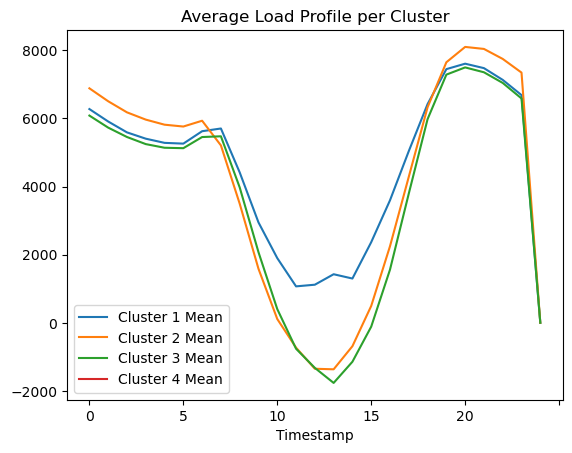

In [73]:
# Usage example:
# cluster_labels, kmeans_model = cluster_load_profiles(actuals_pivot, n_clusters=4)
cluster_labels += 1
# cluster_labels = preds_df['cluster'].values

cluster_1_df_flat, cluster_1_df = get_cluster_profile(actuals_pivot, cluster_labels, cluster_id=1)
cluster_2_df_flat, cluster_2_df = get_cluster_profile(actuals_pivot, cluster_labels, cluster_id=2)
cluster_3_df_flat, cluster_3_df = get_cluster_profile(actuals_pivot, cluster_labels, cluster_id=3)
cluster_4_df_flat, cluster_4_df = get_cluster_profile(actuals_pivot, cluster_labels, cluster_id=4)

px.line(cluster_1_df_flat, x='timestamp', y='value', title='Cluster 1 Load Profile').show()
px.line(cluster_2_df_flat, x='timestamp', y='value', title='Cluster 2 Load Profile').show()
px.line(cluster_3_df_flat, x='timestamp', y='value', title='Cluster 3 Load Profile').show()
px.line(cluster_4_df_flat, x='timestamp', y='value', title='Cluster 4 Load Profile').show()

# actuals_pivot['cluster'] = cluster_labels  # attach clusters back if you want
cluster_1_df.mean().plot(label="Cluster 1 Mean")
cluster_2_df.mean().plot(label="Cluster 2 Mean")
cluster_3_df.mean().plot(label="Cluster 3 Mean")
cluster_4_df.mean().plot(label="Cluster 4 Mean")
plt.legend()
plt.title("Average Load Profile per Cluster")
plt.show()

In [11]:
actuals_pivot

Timestamp,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2024-01-01,276.0,276.0,288.0,282.0,304.0,316.0,339.0,420.0,416.000000,426.0,...,424.0,402.0,366.0,392.0,363.000000,348.0,324.0,306.0,294.0,276.0
2024-01-02,259.2,264.0,258.0,276.0,282.0,312.0,376.0,519.0,856.000000,1149.0,...,1446.0,1416.0,1200.0,1308.0,929.142857,597.0,474.0,408.0,388.0,366.0
2024-01-03,327.0,300.0,294.0,294.0,300.0,318.0,369.0,540.0,835.200000,1094.4,...,1446.0,1420.8,1380.0,1308.0,964.000000,612.0,428.0,384.0,336.0,304.0
2024-01-04,300.0,294.0,284.0,288.0,312.0,336.0,390.0,554.4,861.000000,1084.0,...,1401.0,1395.0,1368.0,1311.0,970.285714,570.0,452.0,376.0,336.0,308.0
2024-01-05,294.0,288.0,282.0,296.0,309.0,312.0,376.0,510.0,840.000000,1113.0,...,1413.0,1425.0,1400.0,1389.0,1183.200000,746.0,480.0,381.0,368.0,340.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,324.0,336.0,328.0,336.0,344.0,360.0,384.0,576.0,946.285714,1272.0,...,1494.0,1524.0,1504.0,1428.0,1066.285714,748.0,606.0,513.6,408.0,378.0
2024-06-27,352.0,352.0,336.0,348.0,357.0,378.0,396.0,542.4,960.000000,1226.4,...,1500.0,1508.0,1500.0,1444.0,1128.000000,717.6,556.0,456.0,438.0,390.0
2024-06-28,354.0,356.0,352.8,356.0,372.0,378.0,396.0,633.6,1012.000000,1264.8,...,1532.0,1524.0,1506.0,1380.0,1267.200000,850.0,573.0,456.0,426.0,384.0
2024-06-29,354.0,352.0,348.0,354.0,366.0,392.0,400.0,512.0,684.000000,933.6,...,1284.0,1196.0,1149.0,1044.0,756.000000,470.4,375.0,363.0,354.0,336.0


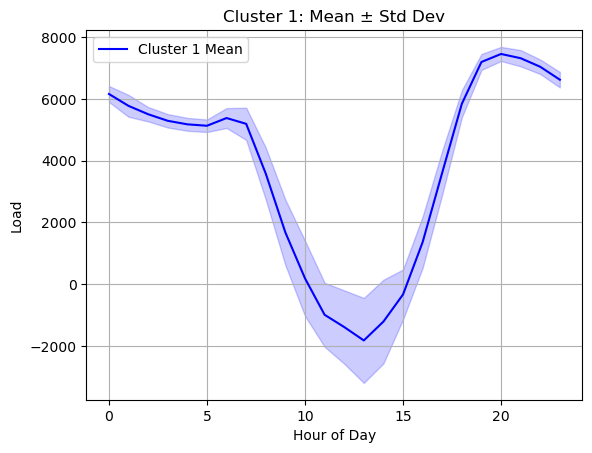

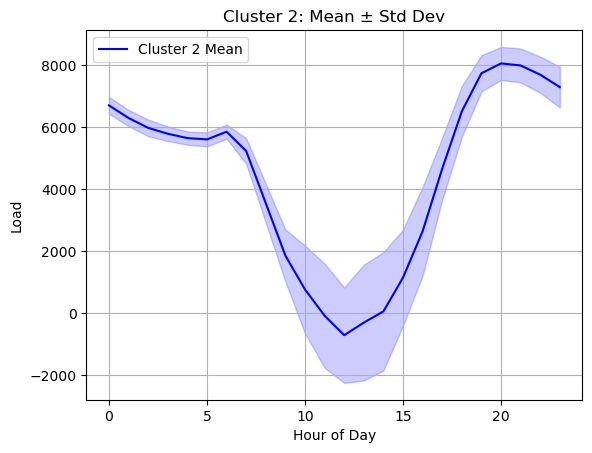

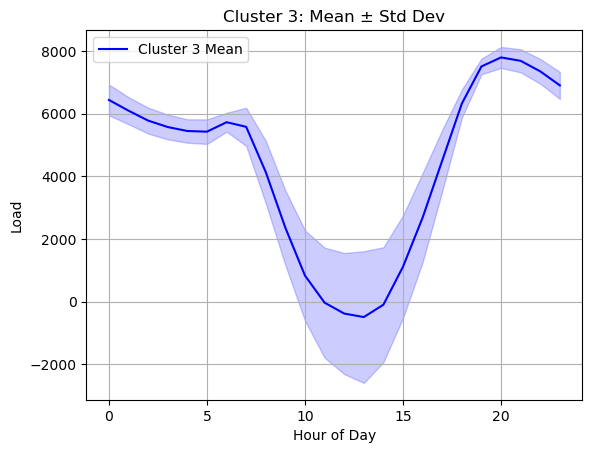

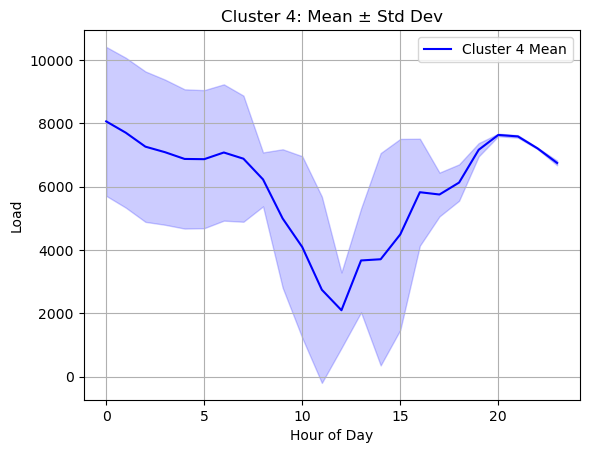

In [66]:
cluster_1_df_mean = cluster_1_df.mean()
cluster_2_df_mean = cluster_2_df.mean()
cluster_3_df_mean = cluster_3_df.mean()
cluster_4_df_mean = cluster_4_df.mean()

cluster_1_df_std = cluster_1_df.std()
cluster_2_df_std = cluster_2_df.std()
cluster_3_df_std = cluster_3_df.std()
cluster_4_df_std = cluster_4_df.std()

def plot_cluster_profiles(mean_profile, std_profile, cluster_id):
    hours = range(24)
    mean_profile = mean_profile.values[:24]
    std_profile = std_profile.values[:24]

    plt.plot(hours, mean_profile, label=f'Cluster {cluster_id} Mean', color='blue')
    plt.fill_between(hours, mean_profile - std_profile, mean_profile + std_profile, color='blue', alpha=0.2)

    plt.xlabel('Hour of Day')
    plt.ylabel('Load')
    plt.title(f'Cluster {cluster_id}: Mean ± Std Dev')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_cluster_profiles(cluster_1_df_mean, cluster_1_df_std, 1)
plot_cluster_profiles(cluster_2_df_mean, cluster_2_df_std, 2)
plot_cluster_profiles(cluster_3_df_mean, cluster_3_df_std, 3)
plot_cluster_profiles(cluster_4_df_mean, cluster_4_df_std, 4)


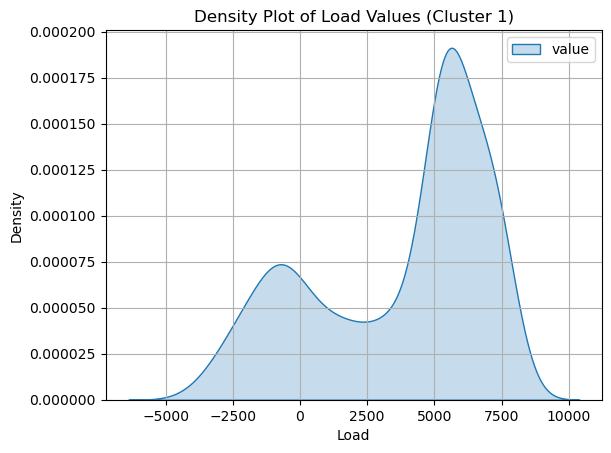

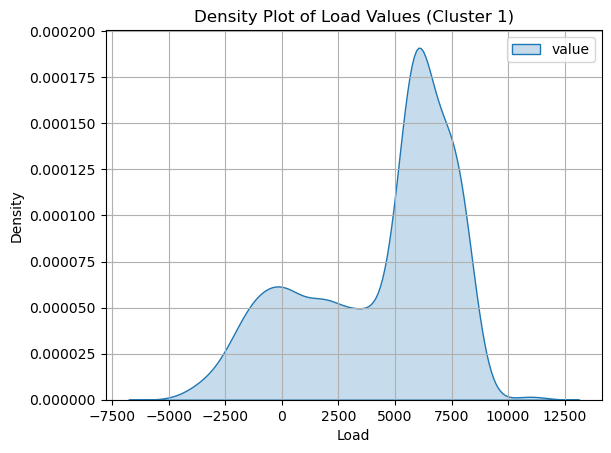

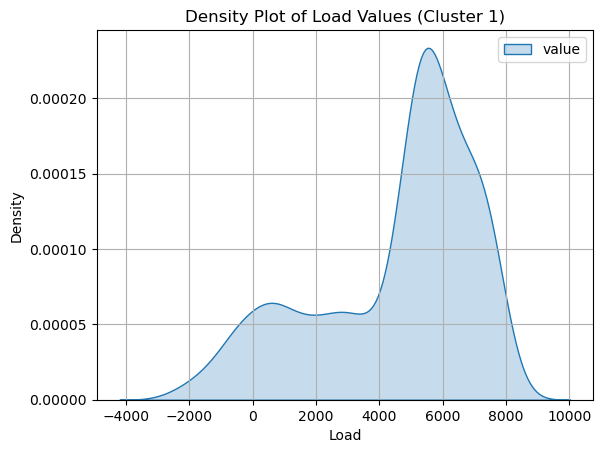

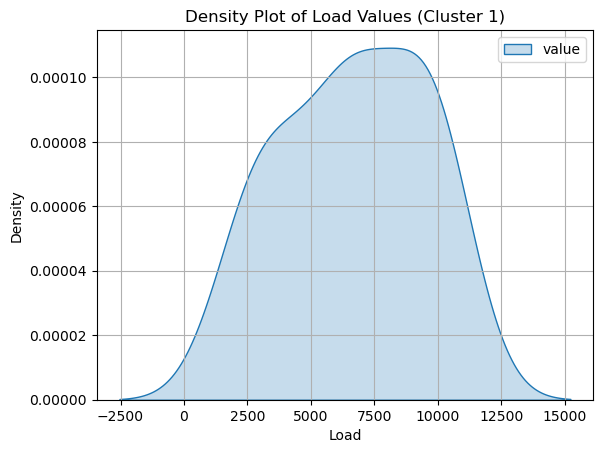

In [45]:
import seaborn as sns

def plot_density(load):
    sns.kdeplot(load, fill=True)
    plt.title('Density Plot of Load Values (Cluster 1)')
    plt.xlabel('Load')
    plt.grid(True)
    plt.show()

# Suppose you have all hourly loads flattened
flattened_loads = cluster_1_df_flat
plot_density(cluster_1_df_flat)
plot_density(cluster_2_df_flat)
plot_density(cluster_3_df_flat)
plot_density(cluster_4_df_flat)


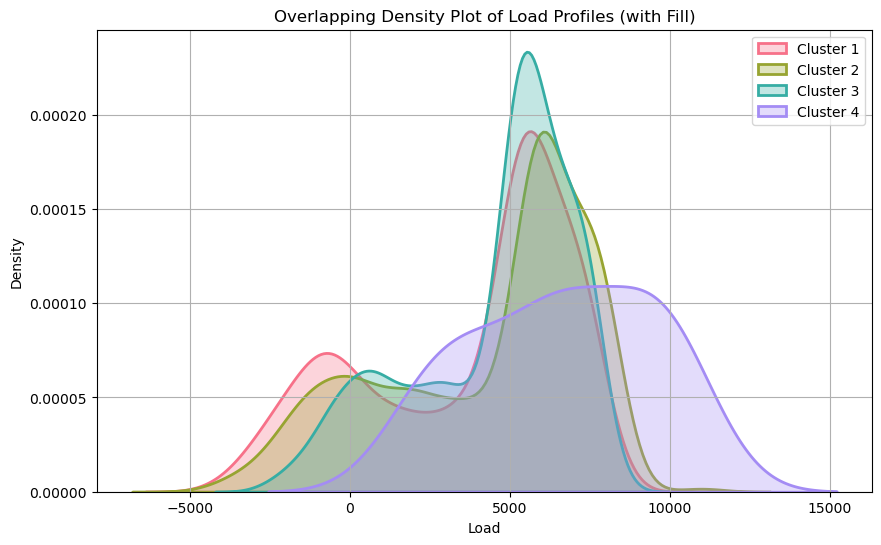

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_density_overlap_filled(cluster_loads_dict):
    """
    Plot overlapping filled density plots for multiple clusters.
    """
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette('husl', n_colors=len(cluster_loads_dict))  # Custom color palette
    
    for (cluster_name, loads), color in zip(cluster_loads_dict.items(), colors):
        sns.kdeplot(loads['value'], label=cluster_name, fill=True, alpha=0.3, linewidth=2, color=color)
    
    plt.title('Overlapping Density Plot of Load Profiles (with Fill)')
    plt.xlabel('Load')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

# Usage
cluster_loads = {
    "Cluster 1": cluster_1_df_flat,
    "Cluster 2": cluster_2_df_flat,
    "Cluster 3": cluster_3_df_flat,
    "Cluster 4": cluster_4_df_flat,
}

plot_density_overlap_filled(cluster_loads)


In [47]:
from scipy.spatial.distance import jensenshannon
import numpy as np

def compute_js_distance(load1, load2, bins=100):
    """
    Compute Jensen-Shannon distance between two flattened load distributions.
    
    Args:
        load1, load2: arrays of flattened load values
        bins: number of bins for histogram (higher = more accurate)
        
    Returns:
        float: Jensen-Shannon distance
    """
    # load1 = load1.values
    # load1 = load1.astype(np.float64)
    # load2 = load2.values
    # load2 = load2.astype(np.float64)
    # Histogram both sets onto same bins
    hist1, bin_edges = np.histogram(load1['value'], bins=bins, density=True)
    hist2, _ = np.histogram(load2['value'], bins=bin_edges, density=True)
    
    # Small value to avoid zero division
    hist1 += 1e-8
    hist2 += 1e-8
    
    return jensenshannon(hist1, hist2)

# Example usage:
js12 = compute_js_distance(cluster_1_df_flat, cluster_2_df_flat)
js13 = compute_js_distance(cluster_1_df_flat, cluster_3_df_flat)
js23 = compute_js_distance(cluster_2_df_flat, cluster_3_df_flat)

print(f"JS Distance Cluster 1 vs 2: {js12:.4f}")
print(f"JS Distance Cluster 1 vs 3: {js13:.4f}")
print(f"JS Distance Cluster 2 vs 3: {js23:.4f}")



JS Distance Cluster 1 vs 2: 0.2564
JS Distance Cluster 1 vs 3: 0.2103
JS Distance Cluster 2 vs 3: 0.2760
